In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("/Users/jasminflack/Desktop/Portfolio/Portfolio-Work/TaylorSwiftProject/taylor_discography_cleaned.csv")
features = df.loc[:,'danceability':'tempo']

In [4]:
def euclidean_distance(a,b,dataframe):
    a_features = dataframe.iloc[a,]
    b_features = dataframe.iloc[b,]
    distance = math.sqrt(np.nansum((a_features-b_features)**2))
    return distance 

In [5]:
#create initial distance matrix
distance_matrix = pd.DataFrame(index=df.name, columns=df.name)

for a in range(0,len(features)):
    for b in range(0,len(features)):
        distance_matrix.iloc[a,b] = euclidean_distance(a,b,features)

distance_matrix = distance_matrix.replace(0,np.nan)
all_distances = pd.DataFrame(columns = ['song', 'closest_song', 'distance'])

In [6]:
#cluster songs
while len(distance_matrix)>9:
    
    #dataframe keeping track of minimum distances for each cluster
    min_distances = pd.DataFrame(columns = ['song', 'closest_song', 'distance'])
    for i in range(0,len(distance_matrix)):
        min_distances.loc[i,:] = [distance_matrix.index.values[i], 
                                  distance_matrix.iloc[i,].idxmin(skipna=True), 
                                  distance_matrix.iloc[i,].min(skipna=True)]
        
    #isolating the cluster pairing with the smallest min distance
    min_pair = min_distances[min_distances['distance'] == min_distances['distance'].min()]
    song1 = min_pair.song.values[0]
    song2 = min_pair.closest_song.values[0]
    
    #dataframe keeping track of each minimum distance cluster pair
    all_distances = pd.concat([all_distances,min_pair])
    
    #updating distance matrix with new cluster, dropping columns and rows of just clustered entries
    clustered_value = (distance_matrix.loc[song1,:] + distance_matrix.loc[song2,:])/2
    distance_matrix.loc[song1,:] = clustered_value
    distance_matrix.rename(index = {song1: song1 + ", " + song2}, 
                           columns = {song1: song1 + ", " + song2},
                           inplace=True)
    distance_matrix.drop(song2,inplace=True)
    distance_matrix.drop(columns = song2,inplace=True)

In [7]:
#final dataframe showing what was clustered at each step and the distances
all_distances.drop_duplicates(subset= 'distance', inplace=True)
all_distances

,song,closest_song,distance
43,Jump Then Fall (Taylor’s Version),...Ready For It?,0.419127
47,Superstar (Taylor’s Version),Getaway Car,0.446631
24,Message In A Bottle (Taylor's Version) (From T...,Forever Winter (Taylor's Version) (From The Va...,0.467627
22,Nothing New (feat. Phoebe Bridgers) (Taylor’s ...,Cornelia Street,0.481902
112,Gorgeous,Out Of The Woods,0.512101
...,...,...,...
10,"Last Kiss, Gorgeous, Out Of The Woods, That’s ...","epiphany, New Year’s Day, All Too Well (10 Min...",10.045545
8,"Better Than Revenge, I'm Only Me When I'm With...","peace, it’s time to go - bonus track, Daylight...",10.192571
4,"Lover, It’s Nice To Have A Friend","Tim McGraw, So It Goes..., Mary's Song (Oh My ...",11.239654
1,State Of Grace (Acoustic Version) (Taylor's Ve...,"Untouchable (Taylor’s Version), Long Live, Tea...",11.259507


In [8]:
#creating a dataframe showing the cluster number for each song
clusters = []
for i in range(0,len(distance_matrix)):
    cluster = distance_matrix.columns[i].split(", ")
    clusters.append(list(zip(cluster,[i]*len(cluster))))

import itertools

flat_list = list(itertools.chain(*clusters))
my_clusters = pd.DataFrame(flat_list, columns = ['song', 'cluster'])
my_clusters

,song,cluster
0,Sad Beautiful Tragic (Taylor's Version),0
1,Blank Space - Voice Memo,0
2,The Moment I Knew (Taylor's Version),0
3,Look What You Made Me Do,0
4,State Of Grace (Taylor's Version),0
...,...,...
173,Blank Space,8
174,All You Had To Do Was Stay,8
175,Fifteen (Taylor’s Version),8
176,Style,8


In [9]:
#clustering algorithm from sklearn
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')
cluster.fit_predict(features)
print(cluster.labels_)

[2 2 6 7 0 6 4 0 6 1 7 2 3 5 2 5 2 5 2 8 3 5 6 0 3 4 3 2 3 1 6 1 3 3 0 2 4
 6 2 7 2 2 1 7 8 3 4 0 7 7 4 2 6 1 6 5 5 0 6 4 4 5 3 3 6 1 2 7 1 4 3 2 4 4
 2 4 5 2 6 1 1 2 3 1 4 1 1 4 3 1 1 0 5 6 2 6 4 6 6 1 7 8 5 1 6 0 5 4 7 7 1
 2 1 2 5 1 0 6 7 3 7 7 1 3 1 1 1 1 7 3 0 2 3 4 7 6 0 0 3 5 3 2 3 3 4 3 3 7
 4 2 7 4 2 7 1 8 7 4 2 4 5 3 5 6 6 3 0 3 4 2 0 5 1 4 1 7 8]


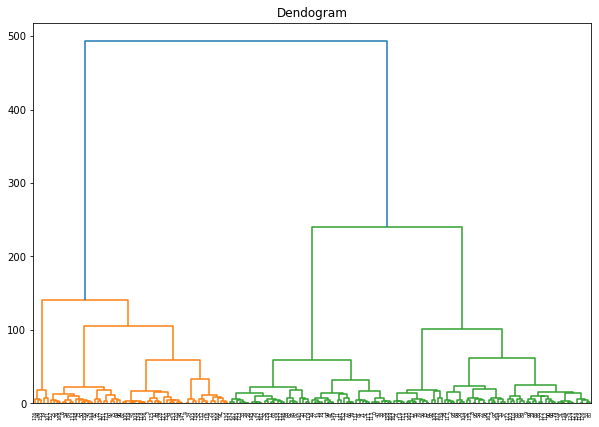

In [10]:
#dendrogram from scipy
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Dendogram")
dend = shc.dendrogram(shc.linkage(features, method='ward'))

In [11]:
#df showing my clusters and sklearn's clusters
scikit_clusters = list(zip(df.name, cluster.labels_))
scikit_clusters = pd.DataFrame(scikit_clusters, columns=["song", "sci-cluster"])
both = my_clusters.merge(scikit_clusters, on='song')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(both)

,song,cluster,sci-cluster
0,Sad Beautiful Tragic (Taylor's Version),0,2
1,Blank Space - Voice Memo,0,2
2,The Moment I Knew (Taylor's Version),0,2
3,Look What You Made Me Do,0,2
4,State Of Grace (Taylor's Version),0,2
5,Forever & Always (Taylor’s Version),0,2
6,You Belong With Me (Taylor’s Version),0,2
7,Superman,0,2
8,Stay Beautiful,0,2
9,You’re Not Sorry (Taylor’s Version),0,2


In [15]:
#printing sklearns cluster classifcations foor each of my clusters
groups = both.groupby(['cluster'])['sci-cluster'].apply(list)
groups = groups.reset_index(name = 'sci_cluster')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(groups)

,cluster,sci_cluster
0,0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
1,1,"[8, 8, 8, 8, 8]"
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, ..."
3,3,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, ..."
4,4,"[0, 0, 0, 0]"
5,5,"[3, 3, 3, 3, 2, 2, 2, 2, 2, 2]"
6,6,"[4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 4, 4, 4, 4, ..."
7,7,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,8,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."


In [16]:
#function for calulating entropy
from scipy.stats import entropy
def entropy1(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  return entropy(counts, base=base)

#printing entropy values for each of my clusterrs
for i in range(0,9):
    print(entropy1(groups.loc[i,'sci_cluster']))

In [18]:
#Saving csv files
all_distances.to_csv('/Users/jasminflack/Desktop/Portfolio/Portfolio-Work/TaylorSwiftProject/all_clusters.csv', index=False)
groups.to_csv('/Users/jasminflack/Desktop/Portfolio/Portfolio-Work/TaylorSwiftProject/cluster_groups.csv', index=False)